In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

## Analyse Dataset

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [3]:
rating_df = pd.read_csv('Ratings.csv')
book_df = pd.read_csv('Books.csv')

In [4]:
users_df = pd.read_csv('Users.csv')
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


<AxesSubplot:>

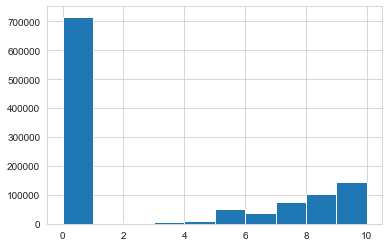

In [5]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df['Book-Rating'].hist()

In [6]:
rating_df.rename(columns = {'User-ID':'userId', 'Book-Title':'item','Book-Rating':'rating'}, inplace = True)
rating_df.head(5)

,userId,ISBN,rating,item,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


### EDA on Rating dataset
- This dataset contain user rating information which will be very handy for recommendation system

In [7]:
x = rating_df.groupby('userId').count()['rating'] > 100
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['userId'].isin(userIndex)]
y = nm_rating_df.groupby('item').count()['rating']>=50
books = y[y].index
final_ratings = nm_rating_df[nm_rating_df['item'].isin(books)]


In [8]:
rating_df=final_ratings

In [9]:
book_ids = list(set(list(rating_df.item.unique())))
user_ids = list(set(list(rating_df.userId.unique()) ))
dict_books = {}
index = 0
for ids in book_ids:
    dict_books[ids] = index
    index += 1
dict_users = {}
index = 0
for ids in user_ids:
    dict_users[ids] = index
    index += 1
rating_df["item"] = rating_df["item"].map(dict_books)
rating_df["userId"] = rating_df["userId"].map(dict_users)
rating_df.head(5)

,userId,ISBN,rating,item,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
413,1431,002542730X,10,27,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
419,1431,0140327592,0,280,Roald Dahl,1990,Viking Penguin Inc,http://images.amazon.com/images/P/0140327592.0...,http://images.amazon.com/images/P/0140327592.0...,http://images.amazon.com/images/P/0140327592.0...
426,1431,0316666343,0,703,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
429,1431,0385504209,8,772,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
453,1431,0804106304,0,557,Amy Tan,1994,Prentice Hall (K-12),http://images.amazon.com/images/P/0804106304.0...,http://images.amazon.com/images/P/0804106304.0...,http://images.amazon.com/images/P/0804106304.0...


### Prepare Train and Test set

- We will consider 10 most recent rated movies by each user as testing data.Out model will be trained on rest of the data

In [10]:
final_ratings=rating_df.sort_values(by=['userId','rating'], ascending=[False,False]) 
final_ratings.shape

(100426, 10)

In [11]:
test_df=rating_df.groupby('userId').head(10)
test_df.shape

(16696, 10)

In [12]:
rating_df=rating_df[~final_ratings.isin(test_df).all(1)]
rating_df.shape

C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(83730, 10)

In [13]:
data=final_ratings

In [14]:
final_ratings

,userId,ISBN,rating,item,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
708869,1793,0425125467,10,1087,Robin Cook,2001,Berkley Publishing Group,http://images.amazon.com/images/P/0425125467.0...,http://images.amazon.com/images/P/0425125467.0...,http://images.amazon.com/images/P/0425125467.0...
708999,1793,0451161343,10,780,Stephen King,1994,Signet Book,http://images.amazon.com/images/P/0451161343.0...,http://images.amazon.com/images/P/0451161343.0...,http://images.amazon.com/images/P/0451161343.0...
708884,1793,0425155404,9,196,Robin Cook,1997,Berkley Publishing Group,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...
708934,1793,044048474X,9,255,JUDY BLUME,1976,Yearling,http://images.amazon.com/images/P/044048474X.0...,http://images.amazon.com/images/P/044048474X.0...,http://images.amazon.com/images/P/044048474X.0...
709003,1793,0451167317,9,88,Stephen King,1994,Signet Book,http://images.amazon.com/images/P/0451167317.0...,http://images.amazon.com/images/P/0451167317.0...,http://images.amazon.com/images/P/0451167317.0...
...,...,...,...,...,...,...,...,...,...,...
505254,0,0452262933,10,667,George Orwell,1983,Plume Books,http://images.amazon.com/images/P/0452262933.0...,http://images.amazon.com/images/P/0452262933.0...,http://images.amazon.com/images/P/0452262933.0...
505247,0,0399501487,9,396,William Gerald Golding,1959,Perigee Trade,http://images.amazon.com/images/P/0399501487.0...,http://images.amazon.com/images/P/0399501487.0...,http://images.amazon.com/images/P/0399501487.0...
505145,0,0140094199,0,338,Raymond Briggs,1982,Penguin USA,http://images.amazon.com/images/P/0140094199.0...,http://images.amazon.com/images/P/0140094199.0...,http://images.amazon.com/images/P/0140094199.0...
505228,0,0330376284,0,991,James Herbert,2000,Pan,http://images.amazon.com/images/P/0330376284.0...,http://images.amazon.com/images/P/0330376284.0...,http://images.amazon.com/images/P/0330376284.0...


## Singular Value Decomposition (SVD) based  Recommendation

###  Step1: Create the rating matrix with rows as movies and columns as users.

In [15]:
ratings_mat = np.ndarray(
    shape=(np.max(data.item.values), np.max(data.userId.values)),
    dtype=np.uint8)
ratings_mat[data.item.values-1, data.userId.values-1] = data.rating.values

### Apply SVD

In [16]:
from scipy.sparse.linalg import svds
normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T
n_factors = 50
#Computing the Singular Value Decomposition (SVD)
A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)
U, S, V = svds (A,n_factors)

In [17]:
book_factors = V.T
user_factors = U

In [18]:
def top_cosine_similarity(data, book, top_n=10):
    index = book - 1 # Movie id starts from 1 in the dataset
    row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]


### Recommendation for book

In [19]:
book_df[book_df['Book-Title']=='1984'].head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2104,0451524934,1984,George Orwell,1990,Signet Book,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...


In [24]:

indexes = [i for i,x in enumerate(book_ids) if x == '1984']
book_id=indexes[0]

In [25]:
def top_cosine_similarity(data, bookid, top_n=10):
    index = bookid 
    row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

In [32]:


top_n = 10
k = 50
top_n = 10
sliced = book_factors[:, :k] # representative data
indexes = top_cosine_similarity(sliced, book_id, top_n)


books = [book_ids[x] for x in indexes]
book_df[book_df['Book-Title'].isin(books)].groupby('Book-Title').head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
221,0385511612,Bleachers,John Grisham,2003,Doubleday,http://images.amazon.com/images/P/0385511612.0...,http://images.amazon.com/images/P/0385511612.0...,http://images.amazon.com/images/P/0385511612.0...
2104,0451524934,1984,George Orwell,1990,Signet Book,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...
2426,0380796090,Watermelon,Marian Keyes,1999,Avon,http://images.amazon.com/images/P/0380796090.0...,http://images.amazon.com/images/P/0380796090.0...,http://images.amazon.com/images/P/0380796090.0...
2864,0684874350,ANGELA'S ASHES,Frank McCourt,1996,Scribner,http://images.amazon.com/images/P/0684874350.0...,http://images.amazon.com/images/P/0684874350.0...,http://images.amazon.com/images/P/0684874350.0...
6382,0452280621,Beloved,Toni Morrison,1998,Plume Books,http://images.amazon.com/images/P/0452280621.0...,http://images.amazon.com/images/P/0452280621.0...,http://images.amazon.com/images/P/0452280621.0...
7709,0553582526,Dust to Dust,TAMI HOAG,2002,Bantam,http://images.amazon.com/images/P/0553582526.0...,http://images.amazon.com/images/P/0553582526.0...,http://images.amazon.com/images/P/0553582526.0...
12451,0446356611,Rage of Angels,Sidney Sheldon,1988,Warner Books,http://images.amazon.com/images/P/0446356611.0...,http://images.amazon.com/images/P/0446356611.0...,http://images.amazon.com/images/P/0446356611.0...
19095,0671003364,Ransom,Julie Garwood,1999,Pocket,http://images.amazon.com/images/P/0671003364.0...,http://images.amazon.com/images/P/0671003364.0...,http://images.amazon.com/images/P/0671003364.0...
21203,055358264X,Dream Country,Luanne Rice,2002,Bantam Books,http://images.amazon.com/images/P/055358264X.0...,http://images.amazon.com/images/P/055358264X.0...,http://images.amazon.com/images/P/055358264X.0...
24998,0440213991,Guardian Angel,Sara Paretsky,1996,Dell Publishing Company,http://images.amazon.com/images/P/0440213991.0...,http://images.amazon.com/images/P/0440213991.0...,http://images.amazon.com/images/P/0440213991.0...


In [54]:
from sklearn.metrics.pairwise import cosine_similarity
def get_recommendations_matrix_factorization(userid, user_factors, book_factors, top_n=10):
    user_vec = user_factors[userid - 1].reshape(1,-1)
    similarity = cosine_similarity(user_vec, book_factors)
    sort_indexes = np.argsort(-similarity)[0]
    return sort_indexes[:top_n]
top_recos = get_recommendations_matrix_factorization(1, user_factors,book_factors)


In [55]:
recommends=[]
for i in top_recos:
    recommends.append(book_ids[i])

In [59]:
book_df[book_df['Book-Title'].isin(recommends)].groupby('Book-Title').head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1129,0446601241,Kiss the Girls,James Patterson,1995,Warner Books,http://images.amazon.com/images/P/0446601241.0...,http://images.amazon.com/images/P/0446601241.0...,http://images.amazon.com/images/P/0446601241.0...
1376,0671038184,Jewel,Bret Lott,1999,Washington Square Press,http://images.amazon.com/images/P/0671038184.0...,http://images.amazon.com/images/P/0671038184.0...,http://images.amazon.com/images/P/0671038184.0...
2921,0446360856,The Gold Coast,Nelson DeMille,1991,Warner Books,http://images.amazon.com/images/P/0446360856.0...,http://images.amazon.com/images/P/0446360856.0...,http://images.amazon.com/images/P/0446360856.0...
3511,0684857820,Lucky,Alice Sebold,1999,Scribner,http://images.amazon.com/images/P/0684857820.0...,http://images.amazon.com/images/P/0684857820.0...,http://images.amazon.com/images/P/0684857820.0...
4202,0440439884,Island of the Blue Dolphins,SCOTT O'DELL,1971,Random House Children's Books,http://images.amazon.com/images/P/0440439884.0...,http://images.amazon.com/images/P/0440439884.0...,http://images.amazon.com/images/P/0440439884.0...
5745,0446606324,The Winner,David Baldacci,1998,Warner Vision,http://images.amazon.com/images/P/0446606324.0...,http://images.amazon.com/images/P/0446606324.0...,http://images.amazon.com/images/P/0446606324.0...
6387,0671026011,The Empty Chair,Jeffery Deaver,2001,Pocket,http://images.amazon.com/images/P/0671026011.0...,http://images.amazon.com/images/P/0671026011.0...,http://images.amazon.com/images/P/0671026011.0...
16354,0553287737,The Bourne Ultimatum,Robert Ludlum,1991,Bantam Books,http://images.amazon.com/images/P/0553287737.0...,http://images.amazon.com/images/P/0553287737.0...,http://images.amazon.com/images/P/0553287737.0...
20584,0449219461,H Is for Homicide (Kinsey Millhone Mysteries (...,Sue Grafton,1993,Fawcett Books,http://images.amazon.com/images/P/0449219461.0...,http://images.amazon.com/images/P/0449219461.0...,http://images.amazon.com/images/P/0449219461.0...
24956,1401088945,Ground Zero and Beyond,J. P. McCarthy,2003,Xlibris Corporation,http://images.amazon.com/images/P/1401088945.0...,http://images.amazon.com/images/P/1401088945.0...,http://images.amazon.com/images/P/1401088945.0...


## Evaluate our result
- We will generate top 10 recommendations for 200 user and calculate the hit rate in test data set.

In [60]:
userlist=list(data.userId.unique())[:200]

In [61]:
data=data[data['userId'].isin(userlist)]

In [62]:
test_df=test_df[test_df['userId'].isin(userlist)]

In [63]:
result=data.sort_values(by=['userId','rating'],ascending=[True,False])
result=result.groupby('userId').head(15)

In [64]:
result[result.item==0].head(5)

,userId,ISBN,rating,item,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
844735,1749,0515130966,7,0,Catherine Coulter,2001,Jove Books,http://images.amazon.com/images/P/0515130966.0...,http://images.amazon.com/images/P/0515130966.0...,http://images.amazon.com/images/P/0515130966.0...


In [ ]:
data.index.get_loc(book_title)

In [66]:
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():

    user=row['userId']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
        
    bookid=row['item'] 
  
    top_recos = get_recommendations_matrix_factorization(user, user_factors,book_factors)
    
    indexes=top_recos
    for ids in indexes:
        if(ids==bookid):
            continue
        if(~((result['item'] == ids) & (result['userId'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [70]:
# Iterating over values
recommendations=[]
for userid, books in recommend_dict.items():
    total=0
    mlist=[]
    for i in books:
        total+=1
        mlist.append(book_ids[i])
        if(total>15):
            break
    recommendations.append([userid,mlist])

In [71]:
recommendations=pd.DataFrame(recommendations,columns=['user_id','books'])

In [72]:
recommendations.head(2) 

,user_id,books
0,1594,"[The Little Friend, Who Moved My Cheese? An Am..."
1,1595,"[Digital Fortress : A Thriller, Without Remors..."


### Calculate Hit Ratio
- See how often we recommended a movie the user actually rated

In [74]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['item'] == rs) & (test_df['userId'] ==i) ].any().any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.0


### Calculate Hit Ratio on most liked items
- See how often we recommended a movie the user actually rated

In [75]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['item'] == rs) & (test_df['userId'] ==i) & (test_df['rating']>4)].any().any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.0


### Calculate MAP@K

In [77]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    
    for rs in results:
        total+=1
        if(test_df[(test_df['item'] == rs) & (test_df['userId'] ==i) ].any().any()):
                hit+=1
               
        
hit_ratio=hit/total   
print(hit_ratio)

0.0
